# 2D Heat Diffusion (explicit)

In [4]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [25]:
#Set some parameters
L = 0.01 #length of domain
nx, ny = 21, 21 #number of points in x and y directions
alpha = 1e-4
dx = L / (nx - 1) #grid size in x
dy = L / (ny - 1) #grid size in y


#Set up grid
x = numpy.linspace(0, L, num=nx)
y = numpy.linspace(0, L, num=ny)

#Initial Conditions - Neumann at boundary = 0
T0 = numpy.full((ny, nx), 20.0)
T0[:, 0] = 100.0 #left boundary
T0[0, :] = 100.0 #bottom boundary - I believe button vice [-1, :]

In [64]:
#Define FTCS function
def ftcs(T0, nt, dt, dx, dy, alpha, qx=0.0, qy=0.0):
    """Compute forward time, central space in 2D"""
    
    T = T0.copy() #deep copy of initial matrix
    sigma_x = alpha * dt / dx**2
    sigma_y = alpha * dt / dy**2 
    
    #Solve for the center of the domain
    ny, nx = T.shape
    I, J = nx // 2, ny // 2 #determine center coordinates, double slash equivalent to int()
    
    for n in range(nt):
        T[1:-1, 1:-1] = (T[1:-1, 1:-1] + 
                         sigma_x * (T[1:-1, :-2] - 2 * T[1:-1, 1:-1] + T[1:-1, 2:]) + 
                         sigma_y * (T[:-2, 1:-1] - 2 * T[1:-1, 1:-1] + T[2:, 1:-1]))
        #Dirichlet Boundary Condition at Bottom and Left - Optional, just included for completeness
        T[:, 0] = 100.0 
        T[0, :] = 100.0 
        #Neumann Boundary Condition at Top and Right
        T[:, -1] = T[:, -2] + qx / dx
        T[-1, :] = T[-2, :] + qy / dy
        #Check center position for initial condition
        if T[J, I] >= 70.0:
            break #get out of for loop once initial condition is met
    print('Number of time steps was' , n + 1, 'to get a center temperature of', T[J, I])
        
    return T

In [65]:
#Solving until the center of the chip reaches 70 degrees T[10, 10]
sigma = 0.25
#As dx = dy, solving for dt is more simple
#dt = dx**2 * sigma / alpha
dt = min(dx, dy)**2 * sigma / alpha
#t = 0.159 #iterative solving - guess and check during class, nt ~ 254
#Using the newly deveoped function with the if check
nt = 500
T = ftcs(T0, nt, dt, dx, dy, alpha)
T[10, 10]

Number of time steps was 256 to get a center temperature of 70.02138294076661


70.02138294076661

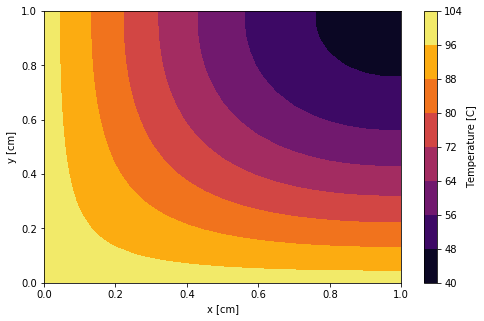

In [75]:
#Creating a 2d contour of the temperature
pyplot.figure(figsize = (8.0, 5.0))
pyplot.xlabel('x [cm]')
pyplot.ylabel('y [cm]')
contf = pyplot.contourf(x * 100, y * 100, T, cmap = 'inferno') #converting m to cm
cbar = pyplot.colorbar(contf)
cbar.set_label('Temperature [C]');

# Solve Using Implicit Method

In [76]:
def btcs(T0, nt, dt, delta, alpha):
    """Solve 2D diffusion (BTCS) given initial 2D field."""
    sigma = alpha * dt / delta**2
    # create LHS operator
    A = lhs_operator()
    T = map_2d_to_1d(T0)
    
    #Integrate in time
    for n in range(nt):
        b = rhs_vector()
        T = numpy.linalg.solve(A,b)
    
    return map_2d_to_1d(T)

In [ ]:
def lhs_operators(M, N):
    A = numpy.zeros((M * N, M * N))
    for j in range(N):
        for i in range(M):
            I = j * M + i
            west = I - 1
            east = I + 1
            south = I - m
            north = I + M
            if i == 0 and j == 0: #bottom left hand corner
                A[I, I] = 1 / sigma + 4
                A[I, east] = -1.0
                A[I, north] = -1.0
            elif i == M - 1 and j == 0: #bottom right hand corner
                A[I, I] = 1 / sigma + 3
                A[I, west] = -1.0
                A[I, north] = -1.0
            elif i == 0 and j == N -1: #top left hand corner
                A[I, I] = 1 / sigma + 3
                A[I, east] = -1.0
                A[I, south] = -1.0
            elif i == M - 1 and j == N - 1: #top right hand corner
                A[I, I] = 1 / sigma + 2
                A[I, west] = -1.0
                A[I, south] = -1.0
            elif j == 0: #first row of all points
                A[I, I] = 1 / sigma + 4
                A[I, west] = -1.0
                A[I, east] = -1.0
                A[I, north] = -1.0
            elif j == N - 1: #last row of interior points
                A[I, I] = 1 / sigma + 3
                A[I, west] = -1.0
                A[I, south] = -1.0
                A[I, east] = -1.0
            elif i == 0: #first column of interior points
                pass
            elif i == M - 1: #last column of interior points
                pass
            else: #is it an interior point with no boundary neighbors
                A[I, I] = 1 / sigma + 4
                A[I, south] = -1.0
                A[I, west] = -1.0
                A[I, east] = -1.0
                A[I, north] = -1.0
                
            return A
            